# Inferring nu_max
* highlighting issue with inferring parameter nu_max from firing rate distribution
* attempts at aleviating issues (expected max-rate bias) (largely unsuccessful) 

## TODO:
* change plots to plotly
* create interactive plot, exploring reference distribution vs changing parameter distribution (p_nu and extreme value)
* ambiguity is not even relieved, when nu_max is fixed -> delta / gamma are still 
* something is wrong in the code... nested sampling always converges at some dlogz >> 1 and then instantly jumps to < 1, accompanied by an apparent jump in parameter values @ heavily drawn away from the "right" ones (which it previously converged to...)


In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
root_dir = Path.cwd().parent
if not root_dir in sys.path: sys.path.insert(0,str(root_dir))

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from inference.BayesModel import *
from empirical.readData import ModelParams

INFO:numexpr.utils:NumExpr defaulting to 12 threads.


In [54]:
def set_likelihood(
    mP,
    mode="ultranest",
    biological=False,
    hierarchical=[],
    two_pop=False,
    correct_N=5,
    bias_to_mean=0,
    bias_to_expected_max=0,
    logLevel=logging.ERROR,
):

    # two_pop = mP.two_pop

    BM = BayesModel(mP, mode="rates")
    # BM.set_logLevel(logging.ERROR)
    BM.set_logLevel(logLevel)
    # BM.prepare_data(mP,mode='rates',key='WT')
    BM.prepare_data(mP, mode="rates")
    BM.set_priors(hierarchical=hierarchical, biological=biological, two_pop=two_pop)
    # BM, results, sampler = run_sampling(mP)

    vectorized = mode == "ultranest"
    my_prior_transform = BM.set_prior_transform(vectorized=vectorized)
    my_likelihood = BM.set_logl(
        vectorized=vectorized,
        correct_N=correct_N,
        bias_to_expected_max=bias_to_expected_max,
        bias_to_mean=bias_to_mean,
        biological=biological,
    )

    return BM, my_prior_transform, my_likelihood

{'distr': [{'gamma': 2.1, 'delta': 4.5, 'nu_max': 25.0}, {'gamma': 1.1, 'delta': 4.5, 'nu_max': 25.0}], 'p': 0.5, 'T': 120, 'N': 1000}
input parameters: gamma=2.1, delta=4.5, nu_max=25.0, gamma=1.1, delta=4.5, nu_max=25.0, 
inferred parameters: rateWnt=[3.4734711564679746, 0.1894257376738134], tau_I=[0.004052847345693511, 0.004052847345693511], alpha_0=[array([[0.02451744]]), array([[0.02207106]])], 
self.two_pop=True


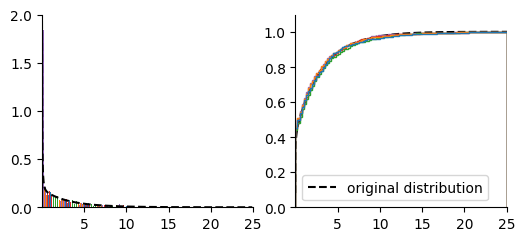

In [ ]:
ref_values = {
    "distr": [
        {"gamma": 2.1, "delta": 4.5, "nu_max": 25.0},
        {"gamma": 1.1, "delta": 4.5, "nu_max": 25.0},
    ],
    "p": 0.3,
    "T": 120,
    "N": 1000,
}
mP = ModelParams(mode="artificial", parameter=ref_values, nAnimals=5)
mP.plot_rates()

In [19]:
BM, res, sampler = run_sampling(
    mP,
    mode="dynesty",
    n_live=100,
    correct_N=0,
    bias_to_expected_max=0.0,
    nP=12,
    # hierarchical=["gamma_1", "delta_1", "gamma_2", "delta_2"],
)

running nested sampling


3362it [00:50, 67.01it/s, +100 | bound: 80 | nc: 1 | ncall: 171369 | eff(%):  2.021 | loglstar:   -inf < -5423.038 <    inf | logz: -5456.503 +/-  0.600 | dlogz:  0.010 >  1.000]


data in:
distr = [{'gamma': 2.1, 'delta': 4.5, 'nu_max': 25.0}, {'gamma': 1.1, 'delta': 4.5, 'nu_max': 25.0}]
p = 0.5
T = 120
N = 1000
p mean: 0.4378270362525399
gamma_0 mean: 2.479608287503884
delta_0 mean: 10.139059982174622
nu_max_0 mean: 22.70600150355037
gamma_1 mean: 1.765272522555713
delta_1 mean: 3.9048878288979534


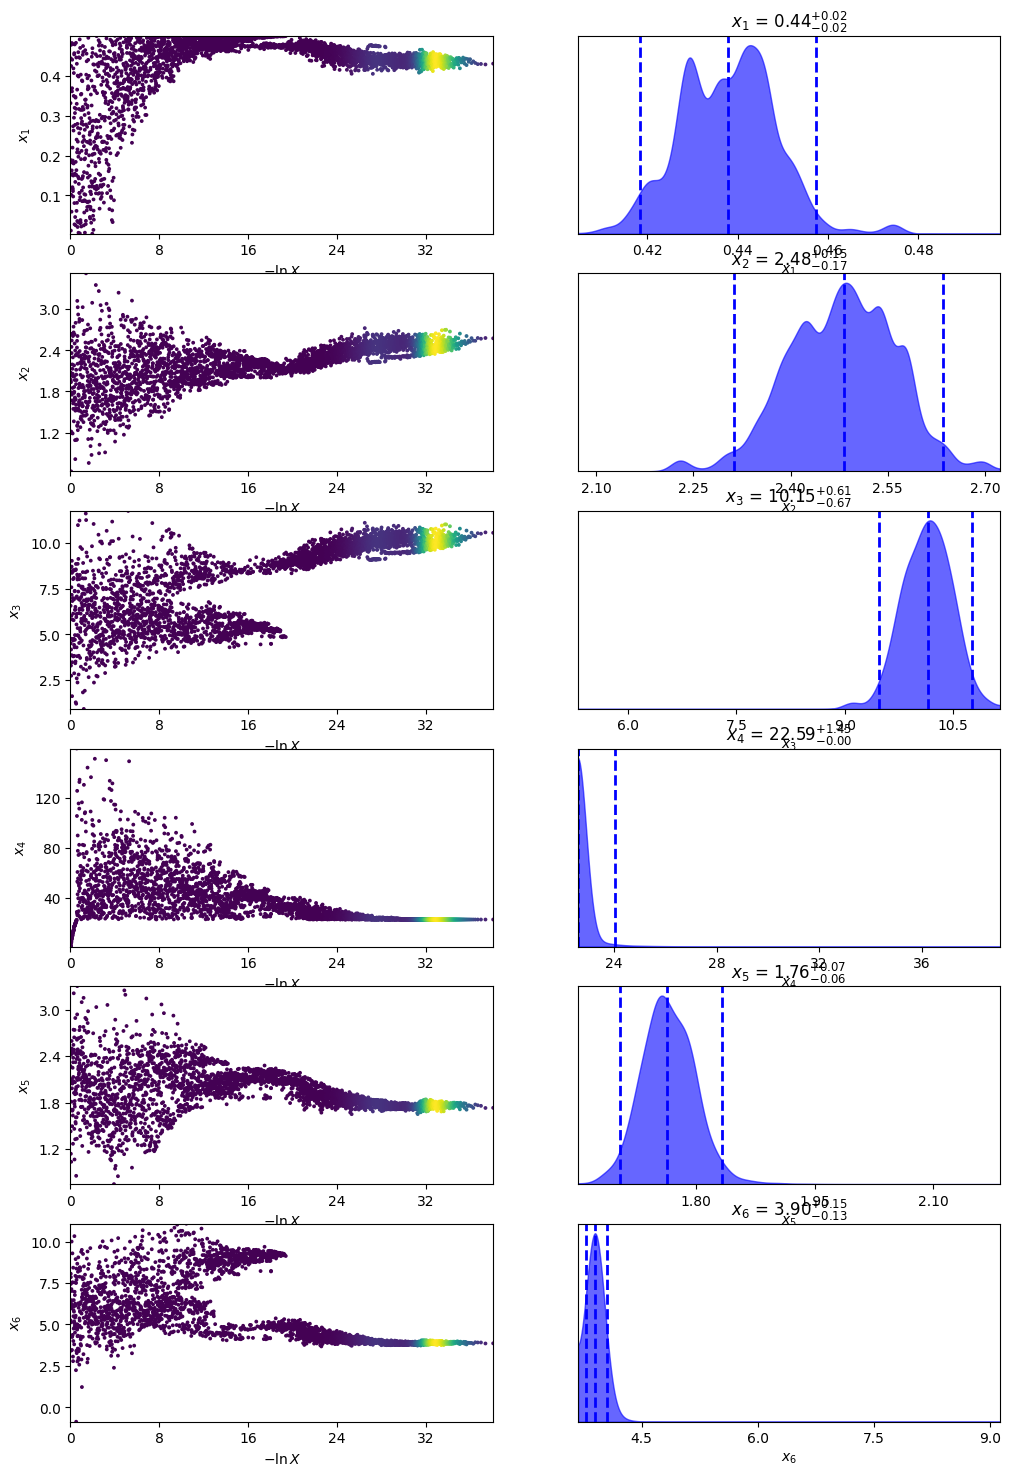

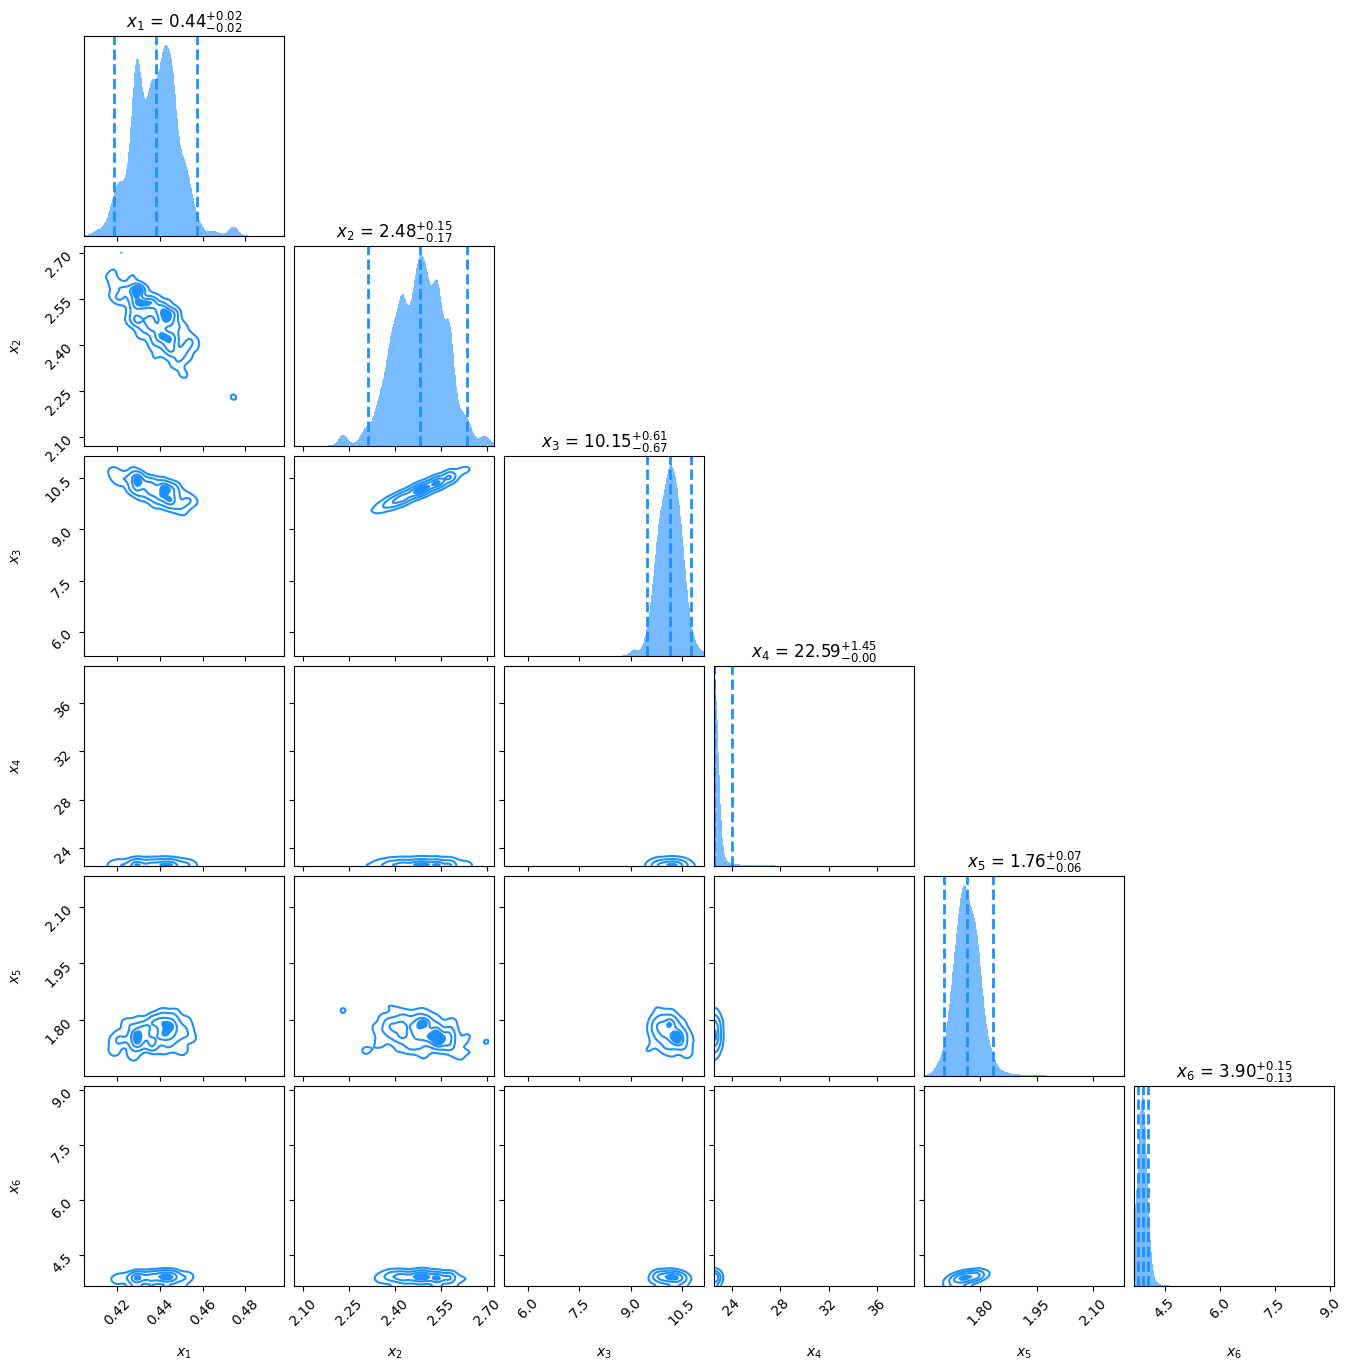


results {'p': 0.4378270362525399, 'gamma_0': 2.479608287503884, 'delta_0': 10.139059982174622, 'nu_max_0': 22.70600150355037, 'gamma_1': 1.765272522555713, 'delta_1': 3.9048878288979534}
self.two_pop=True


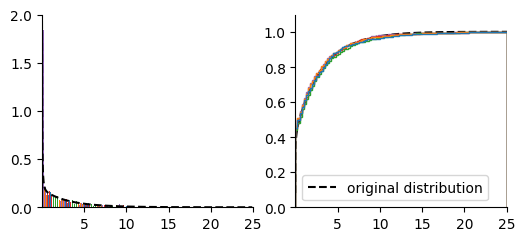

p = 0.4378270362525399
gamma_0 = 2.479608287503884
gamma 0
delta_0 = 10.139059982174622
delta 0
nu_max_0 = 22.70600150355037
nu_max 0
gamma_1 = 1.765272522555713
gamma 1
delta_1 = 3.9048878288979534
delta 1


In [43]:
val_inferred = compare_results(BM, sampler, mP, mode="dynesty")

In [37]:
val_inferred

{'distr': [{'gamma': 1.765272522555713,
   'delta': 3.9048878288979534,
   'nu_max': 22.70600150355037},
  {'gamma': 1.765272522555713,
   'delta': 3.9048878288979534,
   'nu_max': 22.70600150355037}],
 'p': 0.4378270362525399}

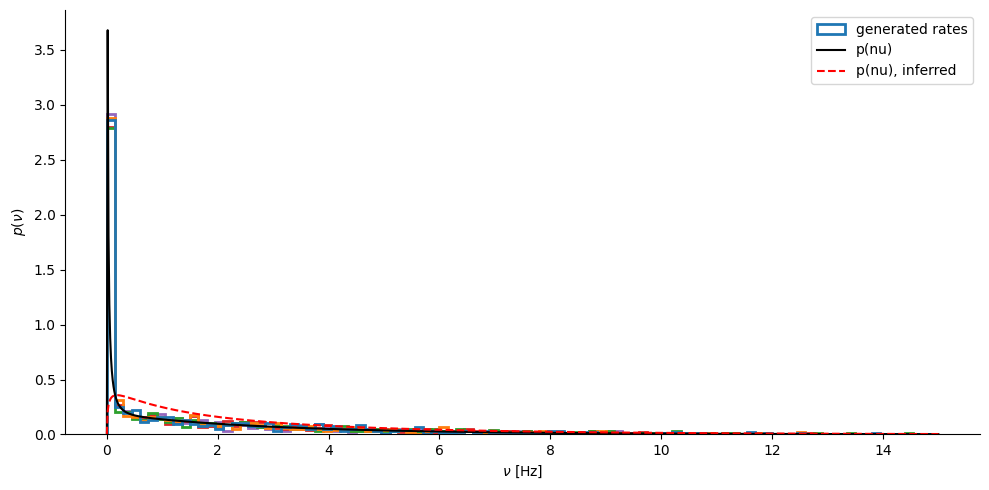

In [42]:
param = ref_values.copy()
# val_inferred = {
#     "distr": [{"gamma": 1.662, "delta": 4.867, "nu_max": 47.310}],
#     "T": 120,
#     "N": 100,
# }
# NU_log = np.logspace(-8, np.log(param["distr"][0]["nu_max"]), 101)
# NU_log = np.logspace(-4, 2, 1001)
NU_log = np.linspace(0, 15, 1001)

p_NU = p_nu(NU_log, param)
p_NU_inferred = p_nu(NU_log, val_inferred)
# fig = plt.figure(figsize=(3, 2.5))
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.hist(
    mP.rates,
    bins=NU_log[::10],
    density=True,
    histtype="step",
    label="generated rates",
    lw=2,
    # color="tab:grey",
)
ax.plot(NU_log, p_NU, label="p(nu)", lw=1.5, color="k")
ax.plot(
    NU_log, p_NU_inferred, label="p(nu), inferred", lw=1.5, color="r", linestyle="--"
)
# plt.xscale("log")
plt.xlabel("$\\nu$ [Hz]")
plt.ylabel("$p(\\nu)$")
ax.spines[["top", "right"]].set_visible(False)

# ax.set_title("p(nu) for nu_max = {}".format(param["distr"][0]["nu_max"]))
ax.legend()
plt.tight_layout()
# plt.savefig("p_nu.png", dpi=300)
plt.show()

In [56]:
mP.rates.max(axis=0)

array([21.36666667, 19.79083333, 17.3325    , 16.89166667, 15.72083333])

In [8]:
res.keys()

['nlive',
 'niter',
 'ncall',
 'eff',
 'samples',
 'blob',
 'samples_id',
 'samples_it',
 'samples_u',
 'logwt',
 'logl',
 'logvol',
 'logz',
 'logzerr',
 'information',
 'bound',
 'bound_iter',
 'samples_bound',
 'scale']

In [28]:
# res["samples"][-330:-200]
res["logz"][-330:-200]

array([-2742.72050507, -2742.72040201, -2742.72029769, -2742.72019209,
       -2742.72008348, -2742.71996639, -2742.71983348, -2742.71969132,
       -2742.7195438 , -2742.71938763, -2742.71922371, -2742.71904595,
       -2742.71884672, -2742.71354895, -2742.7031207 , -2742.69266142,
       -2742.68239221, -2742.67232051, -2742.66244035, -2742.65275208,
       -2742.64324736, -2742.6339214 , -2742.62477215, -2742.61579451,
       -2742.60698296, -2742.5983332 , -2742.58984188, -2742.58149892,
       -2742.57329864, -2742.56524133, -2742.5573252 , -2742.54954829,
       -2742.54190516, -2742.53439225, -2742.52700821, -2742.51974797,
       -2742.51260739, -2742.50558506, -2742.49867935, -2742.49188837,
       -2742.48520835, -2742.47863635, -2742.472171  , -2742.46581011,
       -2742.45955122, -2742.45339197, -2742.44732952, -2742.44136189,
       -2742.43548808, -2742.42970552, -2742.42401198, -2742.41840498,
       -2742.41288274, -2742.40744395, -2742.40208684, -2742.3968105 ,
      

In [53]:
mP.two_pop
BM.two_pop
BM.priors_init

{'p': {'hierarchical': {'function': <function inference.BayesModel.BayesModel.set_priors.<locals>.<lambda>(x, loc, scale)>,
   'params': {'loc': 'mean', 'scale': 'sigma'}},
  'mean': {'params': {},
   'function': <function inference.BayesModel.BayesModel.set_priors.<locals>.<lambda>(x)>},
  'sigma': {'params': {'loc': 0.0, 'scale': 0.1},
   'function': <function inference.BayesModel.BayesModel.set_priors.<locals>.<lambda>(x, loc, scale)>}},
 'gamma_0': {'hierarchical': {'function': <function inference.BayesModel.BayesModel.set_priors.<locals>.<lambda>(x, loc, scale)>,
   'params': {'loc': 'mean', 'scale': 'sigma'}},
  'mean': {'function': <function inference.BayesModel.BayesModel.set_priors.<locals>.<lambda>(x, loc, scale)>,
   'params': {'loc': 2.0, 'scale': 0.5}},
  'sigma': {'function': <function inference.BayesModel.BayesModel.set_priors.<locals>.<lambda>(x, loc, scale)>,
   'params': {'loc': 0, 'scale': 0.1}}},
 'delta_0': {'hierarchical': {'function': <function inference.BayesMod

{'distr': [{'gamma': 2.1, 'delta': 4.5, 'nu_max': 25.0}, {'gamma': 1.1, 'delta': 5.5, 'nu_max': 25.0}], 'p': 0.3, 'T': 120, 'N': 1000}
input parameters: gamma=2.1, delta=4.5, nu_max=25.0, gamma=1.1, delta=5.5, nu_max=25.0, 
inferred parameters: rateWnt=[3.4734711564679746, 0.019718427865958912], tau_I=[0.004052847345693511, 0.004052847345693511], alpha_0=[array([[0.02451744]]), array([[0.00740823]])], 
self.two_pop=True


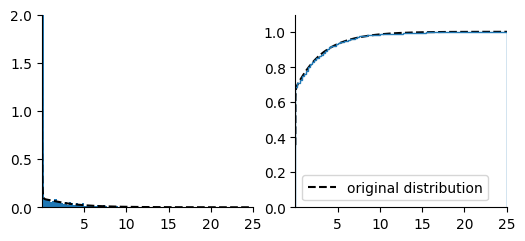

{'distr': [{'gamma': 2.1, 'delta': 4.5, 'nu_max': 25.0}, {'gamma': 1.1, 'delta': 5.5, 'nu_max': 25.0}], 'p': 0.3}


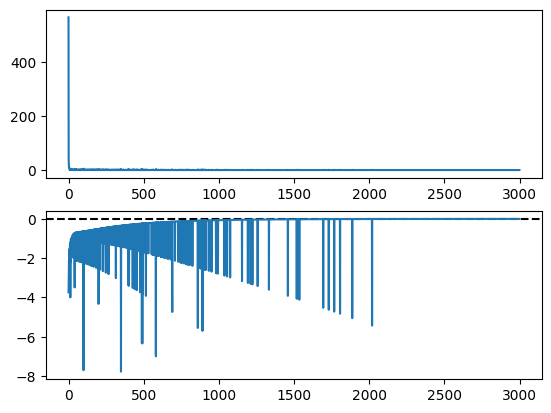

In [82]:
input = np.array([0.3, 2.1, 4.5, 25.0, 1.1, 5.5])

ref_values = {
    "distr": [
        {"gamma": 2.1, "delta": 4.5, "nu_max": 25.0},
        {"gamma": 1.1, "delta": 5.5, "nu_max": 25.0},
    ],
    "p": 0.3,
    "T": 120,
    "N": 1000,
}
mP = ModelParams(mode="artificial", parameter=ref_values, nAnimals=1)
mP.plot_rates()

BM, my_trans, my_logp = set_likelihood(
    mP, correct_N=10, bias_to_expected_max=0.0, two_pop=True
)
logp = my_logp(input)
# logp

In [47]:
input = np.array([1.9, 4.5, 25.0])

logp = my_logp(input)
# plt.figure()
# plt.plot(logp,'r.')
# plt.show()

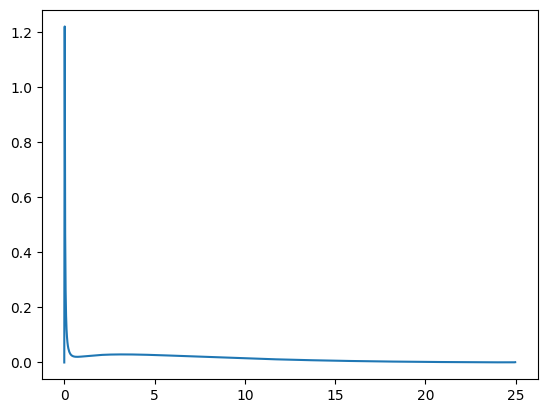

In [ ]:
nu = np.linspace(0, 25, 1001)
ref_values = {
    "distr": [
        {"gamma": 2.1, "delta": 3.5, "nu_max": 25.0},
        {"gamma": 1.1, "delta": 5.5, "nu_max": 25.0},
    ],
    "p": 0.3,
    "T": 120,
    "N": 1000,
}
plt.figure()
plt.plot(nu, p_nu(nu, ref_values), label="p(nu)")
plt.show(block=False)

In [48]:
from joblib import Parallel, delayed

val_range = np.linspace(20, 40.0, 21)
idx = 2

input = np.tile([2.1, 4.5, 25.0], (val_range.shape[0], 1))
input[:, idx] = val_range

# # input = np.tile([2.1, 4.5, 25.0], (1, 1))

BM, my_trans, my_logp = set_likelihood(mP, correct_N=10, bias_to_expected_max=0.0)
steps = 21
# nu_peak = np.zeros((steps, steps))
# logp_peak = np.zeros((steps, steps))

gamma_array = np.linspace(1.1, 2.5, steps)
delta_array = np.linspace(3.0, 6.0, steps)


def compute_row(i, gamma):
    input_row = input.copy()
    input_row[:, 0] = gamma
    nu_row = np.zeros(len(delta_array))
    logp_row = np.zeros(len(delta_array))
    for j, delta in enumerate(delta_array):
        input_row[:, 1] = delta
        logp = my_logp(input_row)
        idx_max = np.argmax(logp)
        nu_row[j] = val_range[idx_max]
        logp_row[j] = logp[idx_max]
    return nu_row, logp_row


results = Parallel(n_jobs=12)(
    delayed(compute_row)(i, gamma) for i, gamma in enumerate(gamma_array)
)

nu_peak = np.array([r[0] for r in results])
logp_peak = np.array([r[1] for r in results])

# print(logp_peak)

-8561.52489764767 -2695.608572086136


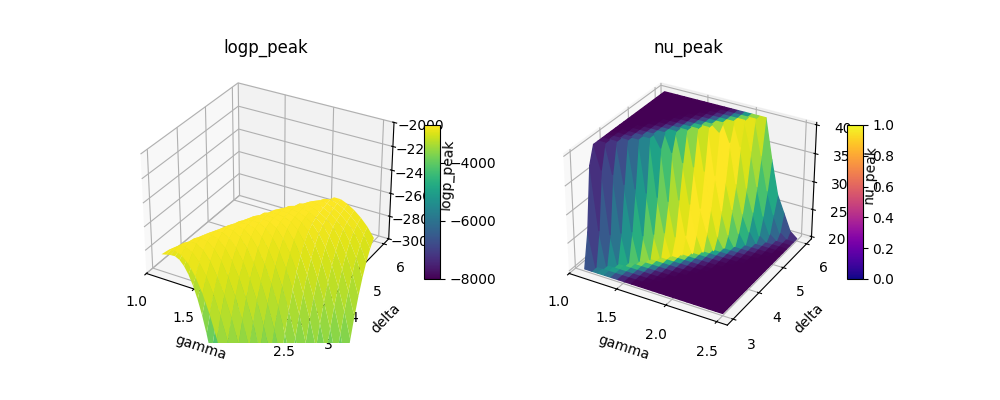

In [49]:
%matplotlib ipympl
logp_peak[logp_peak > -1] = -np.inf
X, Y = np.meshgrid(gamma_array, delta_array)

fig = plt.figure(figsize=(10, 4))

# First subplot: logp_peak
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, logp_peak.T, cmap='viridis')
ax1.set_xlabel('gamma')
ax1.set_ylabel('delta')
ax1.set_zlabel('logp_peak')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title('logp_peak')
ax1.set_zlim([-3000,-2000])

# Second subplot: nu_peak
# Normalize logp_peak for alpha mapping (0 = min, 1 = max)
logp_min, logp_max = np.min(logp_peak[np.isfinite(logp_peak)]), np.max(logp_peak)
print(logp_min, logp_max)
alpha_norm = (logp_peak - logp_min) / (logp_max - logp_min)
# Transpose alpha to match surface shape
alpha_norm = (alpha_norm**50).T

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, nu_peak.T, cmap='plasma', alpha=1.0, facecolors=plt.cm.viridis(alpha_norm))
ax2.set_xlabel('gamma')
ax2.set_ylabel('delta')
ax2.set_zlabel('nu_peak')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title('nu_peak')

plt.show()

In [20]:
def extreme_value_distribution(params, T, n, offset=0.5, cut_off=True):

    ## get N_AP from T & nu_max
    N_max = int(params["distr"][0]["nu_max"] * T)
    N_AP = np.arange(N_max).astype("int")

    ## build p_N_AP
    p_N_AP = get_p_nu(
        (N_AP + offset) / T,
        params,
        T,
        correct_N=10,
        correct_threshold=10 ** (-4),
    )
    ### now, get extreme value distribution
    p_N_AP_cum = np.pad(
        np.cumsum(p_N_AP) ** n,
        (1, 0),
        mode="constant",
        constant_values=0,
    )
    p_extreme = np.diff(p_N_AP_cum)

    if cut_off:
        p_extreme *= 1 - 1.0 / (params["distr"][0]["nu_max"] - N_AP / T + 1) ** 2

    p_extreme /= p_extreme.sum()
    return N_AP / T, p_extreme
    # p_extreme *= 1 - 1.0 / (params["distr"][0]["nu_max"] - N_AP / self.T + 1) ** 2

    # logl_extreme_empirical = np.log(p_extreme[max_spike_count])
    # return bias_to_expected_max * logl_extreme_empirical

In [50]:
import dash
from dash import dcc, html, Input, Output, State
import plotly.graph_objs as go
import numpy as np
from dash_extensions.enrich import DashProxy, Output, Input, MultiplexerTransform
from dash import callback_context

# from plotly.subplots import make_subplots

# --- Assume all your arrays (X, Y, logp_peak_masked, nu_peak, alpha_norm, gamma_array, delta_array, etc.) are already defined ---

app = DashProxy(transforms=[MultiplexerTransform()])

# Prepare the surfaces
surface1 = go.Surface(
    x=X,
    y=Y,
    z=logp_peak.T,
    colorscale="Viridis",
    colorbar=dict(title="logp_peak"),
    name="logp_peak",
    showscale=True,
)
surface2 = go.Surface(
    x=X,
    y=Y,
    z=nu_peak.T,
    surfacecolor=alpha_norm,
    colorscale="Plasma",
    colorbar=dict(title="nu_peak"),
    name="nu_peak",
    showscale=True,
)

# Initial distribution (center or max indices)
max_indices = np.unravel_index(np.argmax(logp_peak), logp_peak.shape)
init_i, init_j = max_indices
init_gamma = gamma_array[init_i]
init_delta = delta_array[init_j]
init_nu_max = nu_peak[init_i, init_j]
params_dist = {
    "distr": [
        {
            "gamma": float(init_gamma),
            "delta": float(init_delta),
            "nu_max": float(init_nu_max),
        }
    ],
}
nu_dist, prob_dist = extreme_value_distribution(params_dist, mP.T, mP.N)
distr = p_nu(nu_dist, params_dist)
distr /= distr.sum()

factor = 10.0

# Layout
app.layout = html.Div(
    [
        html.H2("logp_peak, nu_peak surfaces and nu distribution"),
        html.Div(
            [
                dcc.Graph(
                    id="surface-plot",
                    figure={
                        "data": [surface2],
                        "layout": go.Layout(
                            scene=dict(
                                xaxis_title="gamma",
                                yaxis_title="delta",
                                zaxis_title="nu_peak",
                            ),
                            margin=dict(l=0, r=0, t=40, b=0),
                            width=400,
                            height=400,
                            title="logp_peak and nu_peak surfaces",
                            updatemenus=[],
                        ),
                    },
                    style={"width": "800px", "height": "400px"},
                    config={"displayModeBar": True},
                ),
                dcc.Graph(
                    id="distribution-plot",
                    figure={
                        "data": [
                            go.Histogram(
                                # histfunc='count',
                                # x=np.linspace(0,25,101),
                                x=mP.rates[:, 0],
                                xbins=dict(start=0, end=25, size=factor * 1 / mP.T),
                                # autobinx=False,
                                histnorm="probability",
                                name="rates",
                                marker=dict(color="green", opacity=0.5),
                                opacity=0.5,
                            ),
                            go.Scatter(
                                x=nu_dist,
                                y=distr,
                                mode="lines",
                                name="p_nu",
                                line=dict(color="blue"),
                            ),
                            go.Scatter(
                                x=nu_dist,
                                y=prob_dist,
                                mode="lines",
                                name="extreme_value",
                                line=dict(color="red"),
                            ),
                        ],
                        "layout": go.Layout(
                            xaxis_title="nu",
                            yaxis_title="probability",
                            title=f"nu distribution<br>gamma={init_gamma:.2f}, delta={init_delta:.2f}, nu_max={init_nu_max:.2f}",
                            width=600,
                            height=400,
                            xaxis=dict(range=[0, 40]),
                            yaxis=dict(range=[0, factor * 0.005]),
                        ),
                    },
                    style={"width": "700px", "height": "400px"},
                    config={"displayModeBar": True},
                ),
            ],
            style={
                "display": "flex",
                "flexDirection": "row",
                "alignItems": "flex-start",
            },
        ),
    ]
)


@app.callback(
    Output("distribution-plot", "figure"),
    [
        Input("surface-plot", "hoverData"),
        Input("surface-plot", "clickData"),
    ],
    State("distribution-plot", "figure"),
    prevent_initial_call=True,
)
def update_distribution_on_hover_click(hoverData, clickData, currentFigure):

    triggered = callback_context.triggered
    if not triggered:
        raise dash.exceptions.PreventUpdate

    click = False
    if triggered[0]["prop_id"].startswith("surface-plot.clickData"):
        click = True
        print(f"You clicked the graph: {clickData}")

    currentLayout = currentFigure["layout"]

    # Default to initial values
    click_gamma, click_delta, click_nu_max = init_gamma, init_delta, init_nu_max
    hover_gamma, hover_delta, hover_nu_max = init_gamma, init_delta, init_nu_max

    # Get click parameters if available
    # click = False
    title_string = ""
    if clickData and "points" in clickData:
        # click = True
        point = clickData["points"][0]
        x = point["x"]
        y = point["y"]
        i = (np.abs(gamma_array - x)).argmin()
        j = (np.abs(delta_array - y)).argmin()
        click_gamma = gamma_array[i]
        click_delta = delta_array[j]
        click_nu_max = nu_peak[i, j]

        title_string += f"click: <br>gamma={click_gamma:.2f}, delta={click_delta:.2f}, nu_max={click_nu_max:.2f}"

    # print("click?",click)
    # Get hover parameters if available
    if hoverData and "points" in hoverData:
        point = hoverData["points"][0]
        x = point["x"]
        y = point["y"]
        i = (np.abs(gamma_array - x)).argmin()
        j = (np.abs(delta_array - y)).argmin()
        hover_gamma = gamma_array[i]
        hover_delta = delta_array[j]
        hover_nu_max = nu_peak[i, j]

        title_string += f"\nhover: <br>gamma={hover_gamma:.2f}, delta={hover_delta:.2f}, nu_max={hover_nu_max:.2f}"

    currentLayout["title"] = title_string

    # Compute distributions for click
    click_params = {
        "distr": [
            {
                "gamma": float(click_gamma),
                "delta": float(click_delta),
                "nu_max": float(click_nu_max),
            }
        ],
    }
    click_nu_dist, click_prob_dist = extreme_value_distribution(
        click_params, mP.T, mP.N
    )
    click_prob_dist *= factor
    click_distr = p_nu(click_nu_dist, click_params)
    click_distr /= click_distr.sum()
    click_distr *= factor

    # Compute distributions for hover
    hover_params = {
        "distr": [
            {
                "gamma": float(hover_gamma),
                "delta": float(hover_delta),
                "nu_max": float(hover_nu_max),
            }
        ],
    }
    hover_nu_dist, hover_prob_dist = extreme_value_distribution(
        hover_params, mP.T, mP.N
    )
    hover_prob_dist *= factor
    hover_distr = p_nu(hover_nu_dist, hover_params)
    hover_distr /= hover_distr.sum()
    hover_distr *= factor

    # Click (left)
    distributions = [currentFigure["data"][0]]
    if click:
        distributions.append(
            go.Scatter(
                x=click_nu_dist,
                y=click_distr,
                mode="lines",
                name="p_nu (click)",
                line=dict(color="blue"),
            )
        )
        distributions.append(
            go.Scatter(
                x=click_nu_dist,
                y=click_prob_dist,
                mode="lines",
                name="max_distribution (click)",
                line=dict(color="red"),
            )
        )
    else:
        distributions.append(currentFigure["data"][1])
        distributions.append(currentFigure["data"][2])

    # Hover (right)
    distributions.append(
        go.Scatter(
            x=hover_nu_dist,
            y=hover_distr,
            mode="lines",
            name="p_nu (hover)",
            line=dict(color="blue", dash="dash"),
        ),
    )
    distributions.append(
        go.Scatter(
            x=hover_nu_dist,
            y=hover_prob_dist,
            mode="lines",
            name="max_distribution (hover)",
            line=dict(color="red", dash="dash"),
        )
    )
    # fig.update_xaxes(title_text="nu", range=[0, 50], row=1, col=1)
    # fig.update_xaxes(title_text="nu", range=[0, 50], row=1, col=2)
    # fig.update_yaxes(title_text="probability", row=1, col=1)
    # fig.update_layout(
    # 	width=900,
    # 	height=400,
    # 	title_text="nu distribution: click (left) vs hover (right)",
    # 	showlegend=True,
    # )
    return {"data": distributions, "layout": currentLayout}


if __name__ == "__main__":
    app.run_server(debug=True)

You clicked the graph: {'points': [{'x': 1.8, 'y': 3.45, 'z': 20, 'curveNumber': 0, 'surfacecolor': 0.02180448566057961, 'bbox': {'x0': 106.09128599469877, 'x1': 106.09128599469877, 'y0': 369.5945217403377, 'y1': 369.5945217403377}}]}
You clicked the graph: {'points': [{'x': 1.73, 'y': 4.65, 'z': 28, 'curveNumber': 0, 'surfacecolor': 0.4310657065489828, 'bbox': {'x0': 161.96926190752407, 'x1': 161.96926190752407, 'y0': 296.098970959069, 'y1': 296.098970959069}}]}
You clicked the graph: {'points': [{'x': 1.73, 'y': 4.5, 'z': 23, 'curveNumber': 0, 'surfacecolor': 0.7519069530325555, 'bbox': {'x0': 156.9116288507545, 'x1': 156.9116288507545, 'y0': 335.1895574810287, 'y1': 335.1895574810287}}]}


In [14]:
# plt.figure()
# plt.hist(mP.rates,bins=np.arange(0,25,0.5),density=True)
mP.rates.max()

18.9825

In [375]:
max_indices = np.unravel_index(np.argmax(logp_peak), logp_peak.shape)
print("Indices of maximum value in logp_peak:", max_indices)
gamma_array[max_indices[0]], delta_array[max_indices[1]], nu_peak[max_indices]

Indices of maximum value in logp_peak: (1, 0)


(1.2000000000000002, 3.0, 15.0)

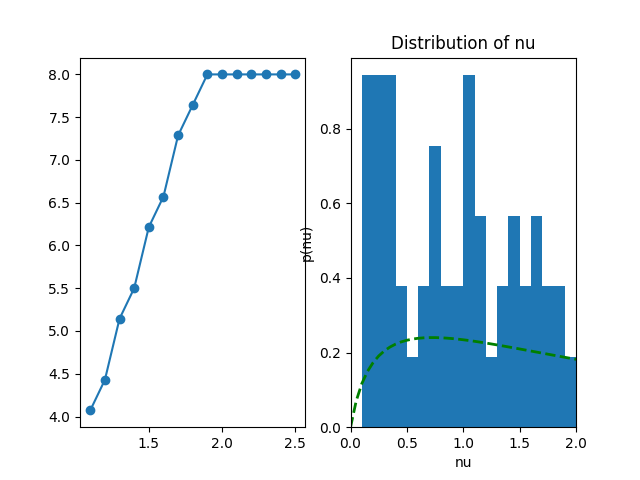

In [36]:
"""
Plot expected max distribution! (create function for that which is referenced in Bayes Model)
"""

idx = np.argmax(logp_peak, axis=0)

fig = plt.figure()
ax = fig.add_subplot(121)
# print(gamma_array)
# print(delta_array[idx])
ax.plot(gamma_array, delta_array[idx], "o-")

ax_distr = fig.add_subplot(122)
ax_distr.set_title("Distribution of nu")
ax_distr.set_xlabel("nu")
ax_distr.set_ylabel("p(nu)")

NU = np.linspace(0, 50, 1001)
params = {"distr": [{}]}
for i in range(steps):
    params["distr"][0] = {
        "gamma": gamma_array[i],
        "delta": delta_array[idx[i]],
        "nu_max": nu_peak[i, idx[i]],
    }
    # print(params)
    # print(p_nu(NU, params))
    if logp_peak[i, idx[i]] > np.max(logp_peak) - 100:
        # print('plotting')
        print(
            f"logp: {logp_peak[i, idx[i]]}, gamma={gamma_array[i]:.2f}, delta={delta_array[idx[i]]:.2f}, nu_max={nu_peak[i, idx[i]]:.2f}"
        )
        # print(params)
        # print(p_nu(NU, params))
        ax_distr.plot(
            NU, p_nu(NU, params), color=[i / steps, 0, 0]
        )  # ,label = f'gamma={gamma_array[i]:.2f}, delta={delta_array[idx[i]]:.2f}')
ax_distr.set_xlim([-0, 2.0])
ax_distr.hist(mP.rates, bins=np.linspace(-0.05, 2.05, 22), density=True, align="right")
ax_distr.plot(NU, p_nu(NU, ref_values), "g--", linewidth=2)
# mP.plot_rates()
# ax = plt.gca()
# ax.set_ylim([0, 2])

In [ ]:
# BM.binom[0]["k_AP"]
np.linspace(-0.05, 2.05, 22)
# BM.T
# logp_peak[0,logp_peak.argmax()] = -np.inf

array([-0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
        0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,  1.65,
        1.75,  1.85,  1.95,  2.05])

In [ ]:
params["distr"][0]["nu_max"] = 25.0
params

{'distr': [{'gamma': 2.5, 'delta': 8.0, 'nu_max': 25.0}]}

array([-217.7914103 , -159.53008648, -128.92454548, -109.00352207,
        -94.64147817,  -83.63844728,  -74.86059063,  -67.6523284 ,
        -61.60323273,  -56.44079846,  -52.08468655,  -48.2734455 ,
        -44.90920067,  -41.91670845,  -39.23734898,  -36.82462955,
        -34.64110933,  -32.65623776,  -30.84479874,  -29.18576736,
        -27.66145451,  -26.25685675,  -24.95915512,  -23.75732406,
        -22.64182267,  -21.60434861,  -20.63764009,  -19.73531519,
        -18.89174043,  -18.10192254,  -17.36141879,  -16.66626203,
        -16.01289798,  -15.39813215,  -14.81908495,  -14.27315338,
        -13.75797829,  -13.27141618,  -12.81151492,  -12.37649268,
        -11.96471964,  -11.57470202,  -11.2050681 ,  -10.85455593,
        -10.52200257,  -10.2063345 ,   -9.9065592 ,   -9.62175765,
         -9.35107763,   -9.09372781,   -8.84897238,   -8.6161263 ,
         -8.39455101,   -8.18365059,   -7.98286827,   -7.79168331,
         -7.60960812,   -7.43618574,   -7.27098746,   -7.11361

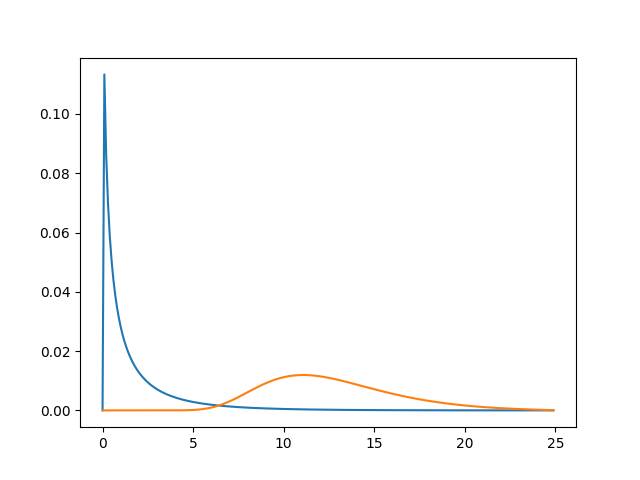

In [ ]:
params = {
    "distr": [{"gamma": 1.7, "delta": 4.5, "nu_max": 25.0}],
    "T": 10,
    "N": 100,
}

nu, prob = extreme_value_distribution(params, params["T"], params["N"])
# prob /= prob.sum()  # * (params['distr'][0]['nu_max']*T)
fig = plt.figure()
ax = fig.add_subplot(111)
distr = p_nu(nu, params)
distr /= distr.sum()
ax.plot(nu, distr)
ax.plot(nu, prob)

# distr.sum()
# prob.sum()
# np.log(prob)

(0.0, 1.0)

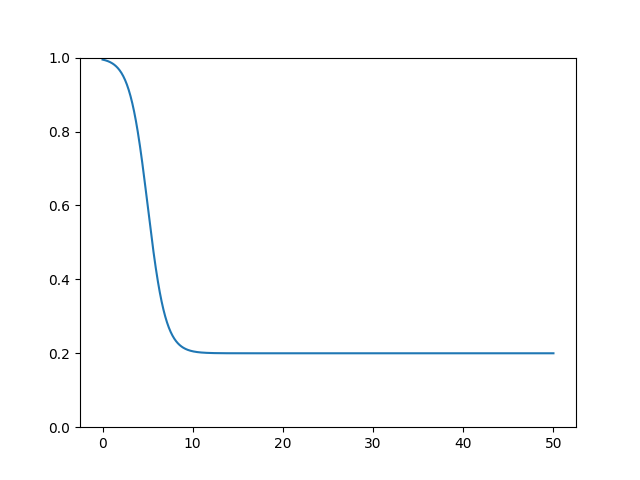

In [225]:
# BM.data["nNeurons"]
def fun(x, a, b, theta):
    # return a + (1-a)/np.log(np.exp(1)+1/(1-x))
    return a + (1 - a) / (1 + np.exp(b * (x - theta)))


fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(NU,1/(np.exp(NU*10/100)+0.1))
ax.plot(NU, fun(NU / NU.max(), 0.2, 50, 0.1))
ax.set_ylim([0, 1])